# Exploratory Data Analysis (EDA)
In this notebook, we explore the data. The tasks covered include:
1. Investigate every feature using histograms, bi-plots and other visual and numerical means.
2. Compute Pearson correlation coefficients and other statistical methods to identify statistical relationship strengths.
3. Make data-supported decisions on when to select specific features

## Data story
The quality of wine is dependent on many different factors. Wine quality may depend on features that can be measured in a quantitative way, such as its chemical composition. Wine quality depends in part on getting the basics right. Sugars, alcohol and acids that are far outside of the normal range are likely to spoil the wine and result in low quality. The very finest wine may depend on features that are difficult to quantify.

In some respects, it's reasonable to attempt an estimate of wine quality from simple physicochemical measurements. We also expect that some aspects of high quality can't be captured in this way. Some of the variance in the dataset may not be explained by physicochemistry.

In this dataset, we are examining several thousand samples of wine that have been measured for the following:

1. Fixed acidity
2. Volatile acidity
3. Citric acid
4. Residual sugar
5. Chlorides
6. Free sulfur dioxide
7. Total sulfur dioxide
8. Density
9. pH
10. Sulphates
11. Alcohol

Due to the nature of chemistry, some features will be highly correlated. For example, density is largely a function of the major components of wine: water, alcohol and sugar, and to a lesser extent by the smaller fractional components such as acids, chlorides, sulfur dioxide and sulphates.

In the EDA phase, we will examine correlations between the features and begin to consider feature engineering and selection.

In [4]:
import pandas as pd

wine = pd.read_csv('../data/all_wines.csv',index_col = False)

In [5]:
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  type_white  
0      8.8        6           1  
1      9.5        6           1  
2     10.1        6           1  
3      9.9        6           1  
4      9.9        6           1

In [8]:
# Helper function for an array of boxplots

import matplotlib.pyplot as plt

def boxplots(df):
    num_columns_to_plot = len(df.columns)
    num_columns = 4
    num_rows = -(-num_columns_to_plot // 4)
    col_names = df.columns
    plt.figure(figsize=(24,12))
    for i, col in enumerate(col_names):
        plt.subplot(num_rows,num_columns,i+1)
        df.boxplot(column = col,fontsize=18)
    plt.tight_layout()
    plt.show()

Let's review the range of each variable using boxplots:

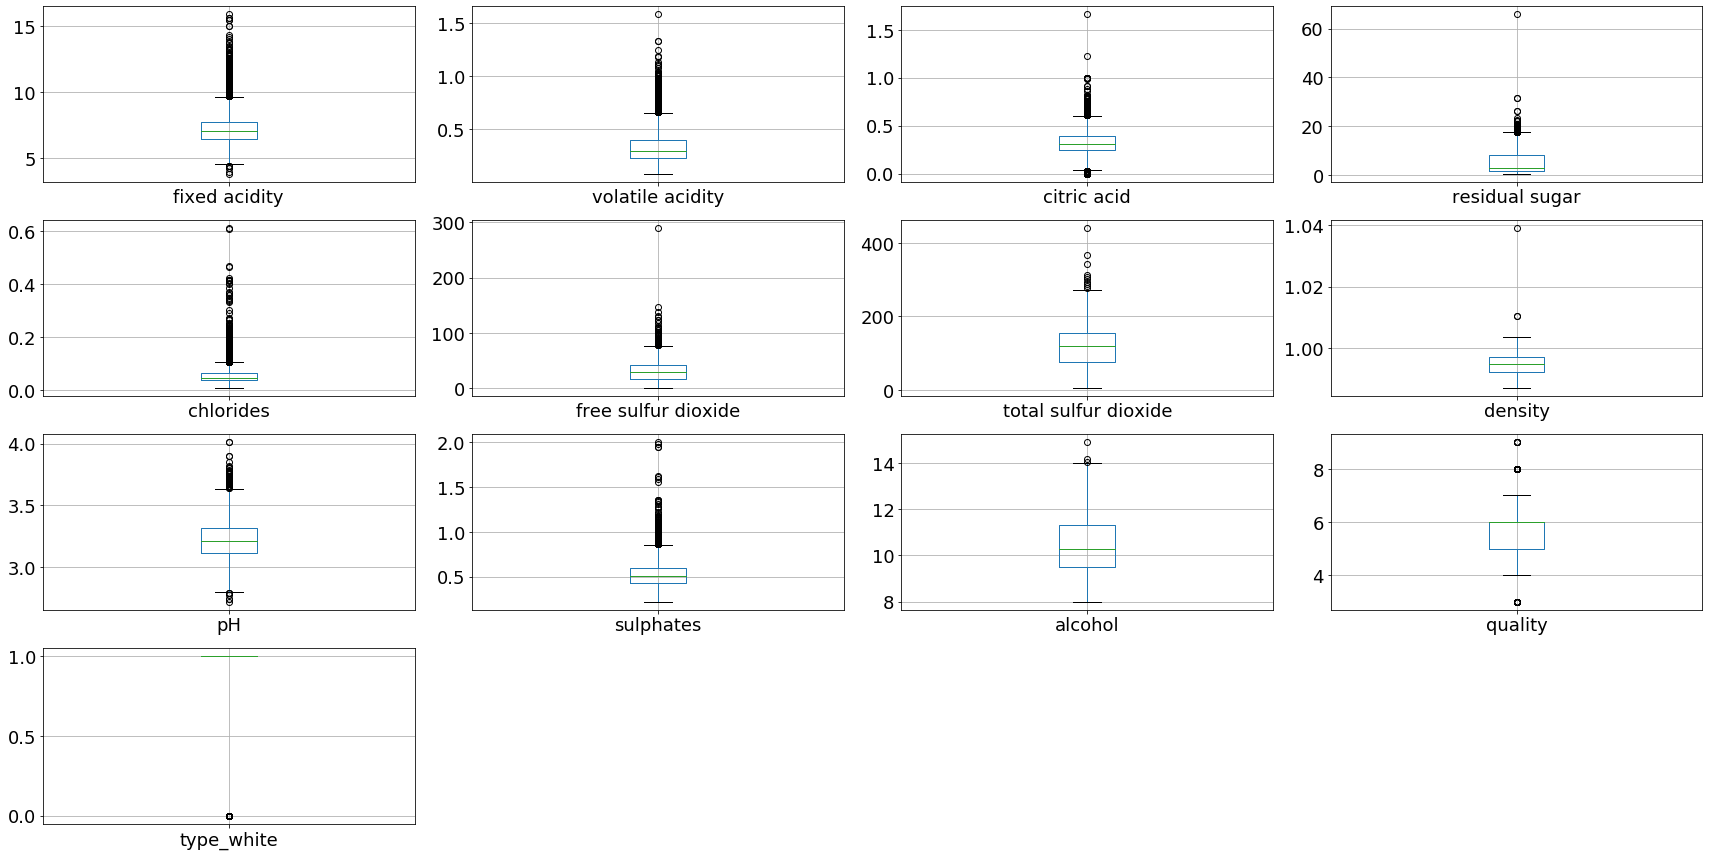

In [9]:
boxplots(wine)

Let's look for correlations with pairplots:

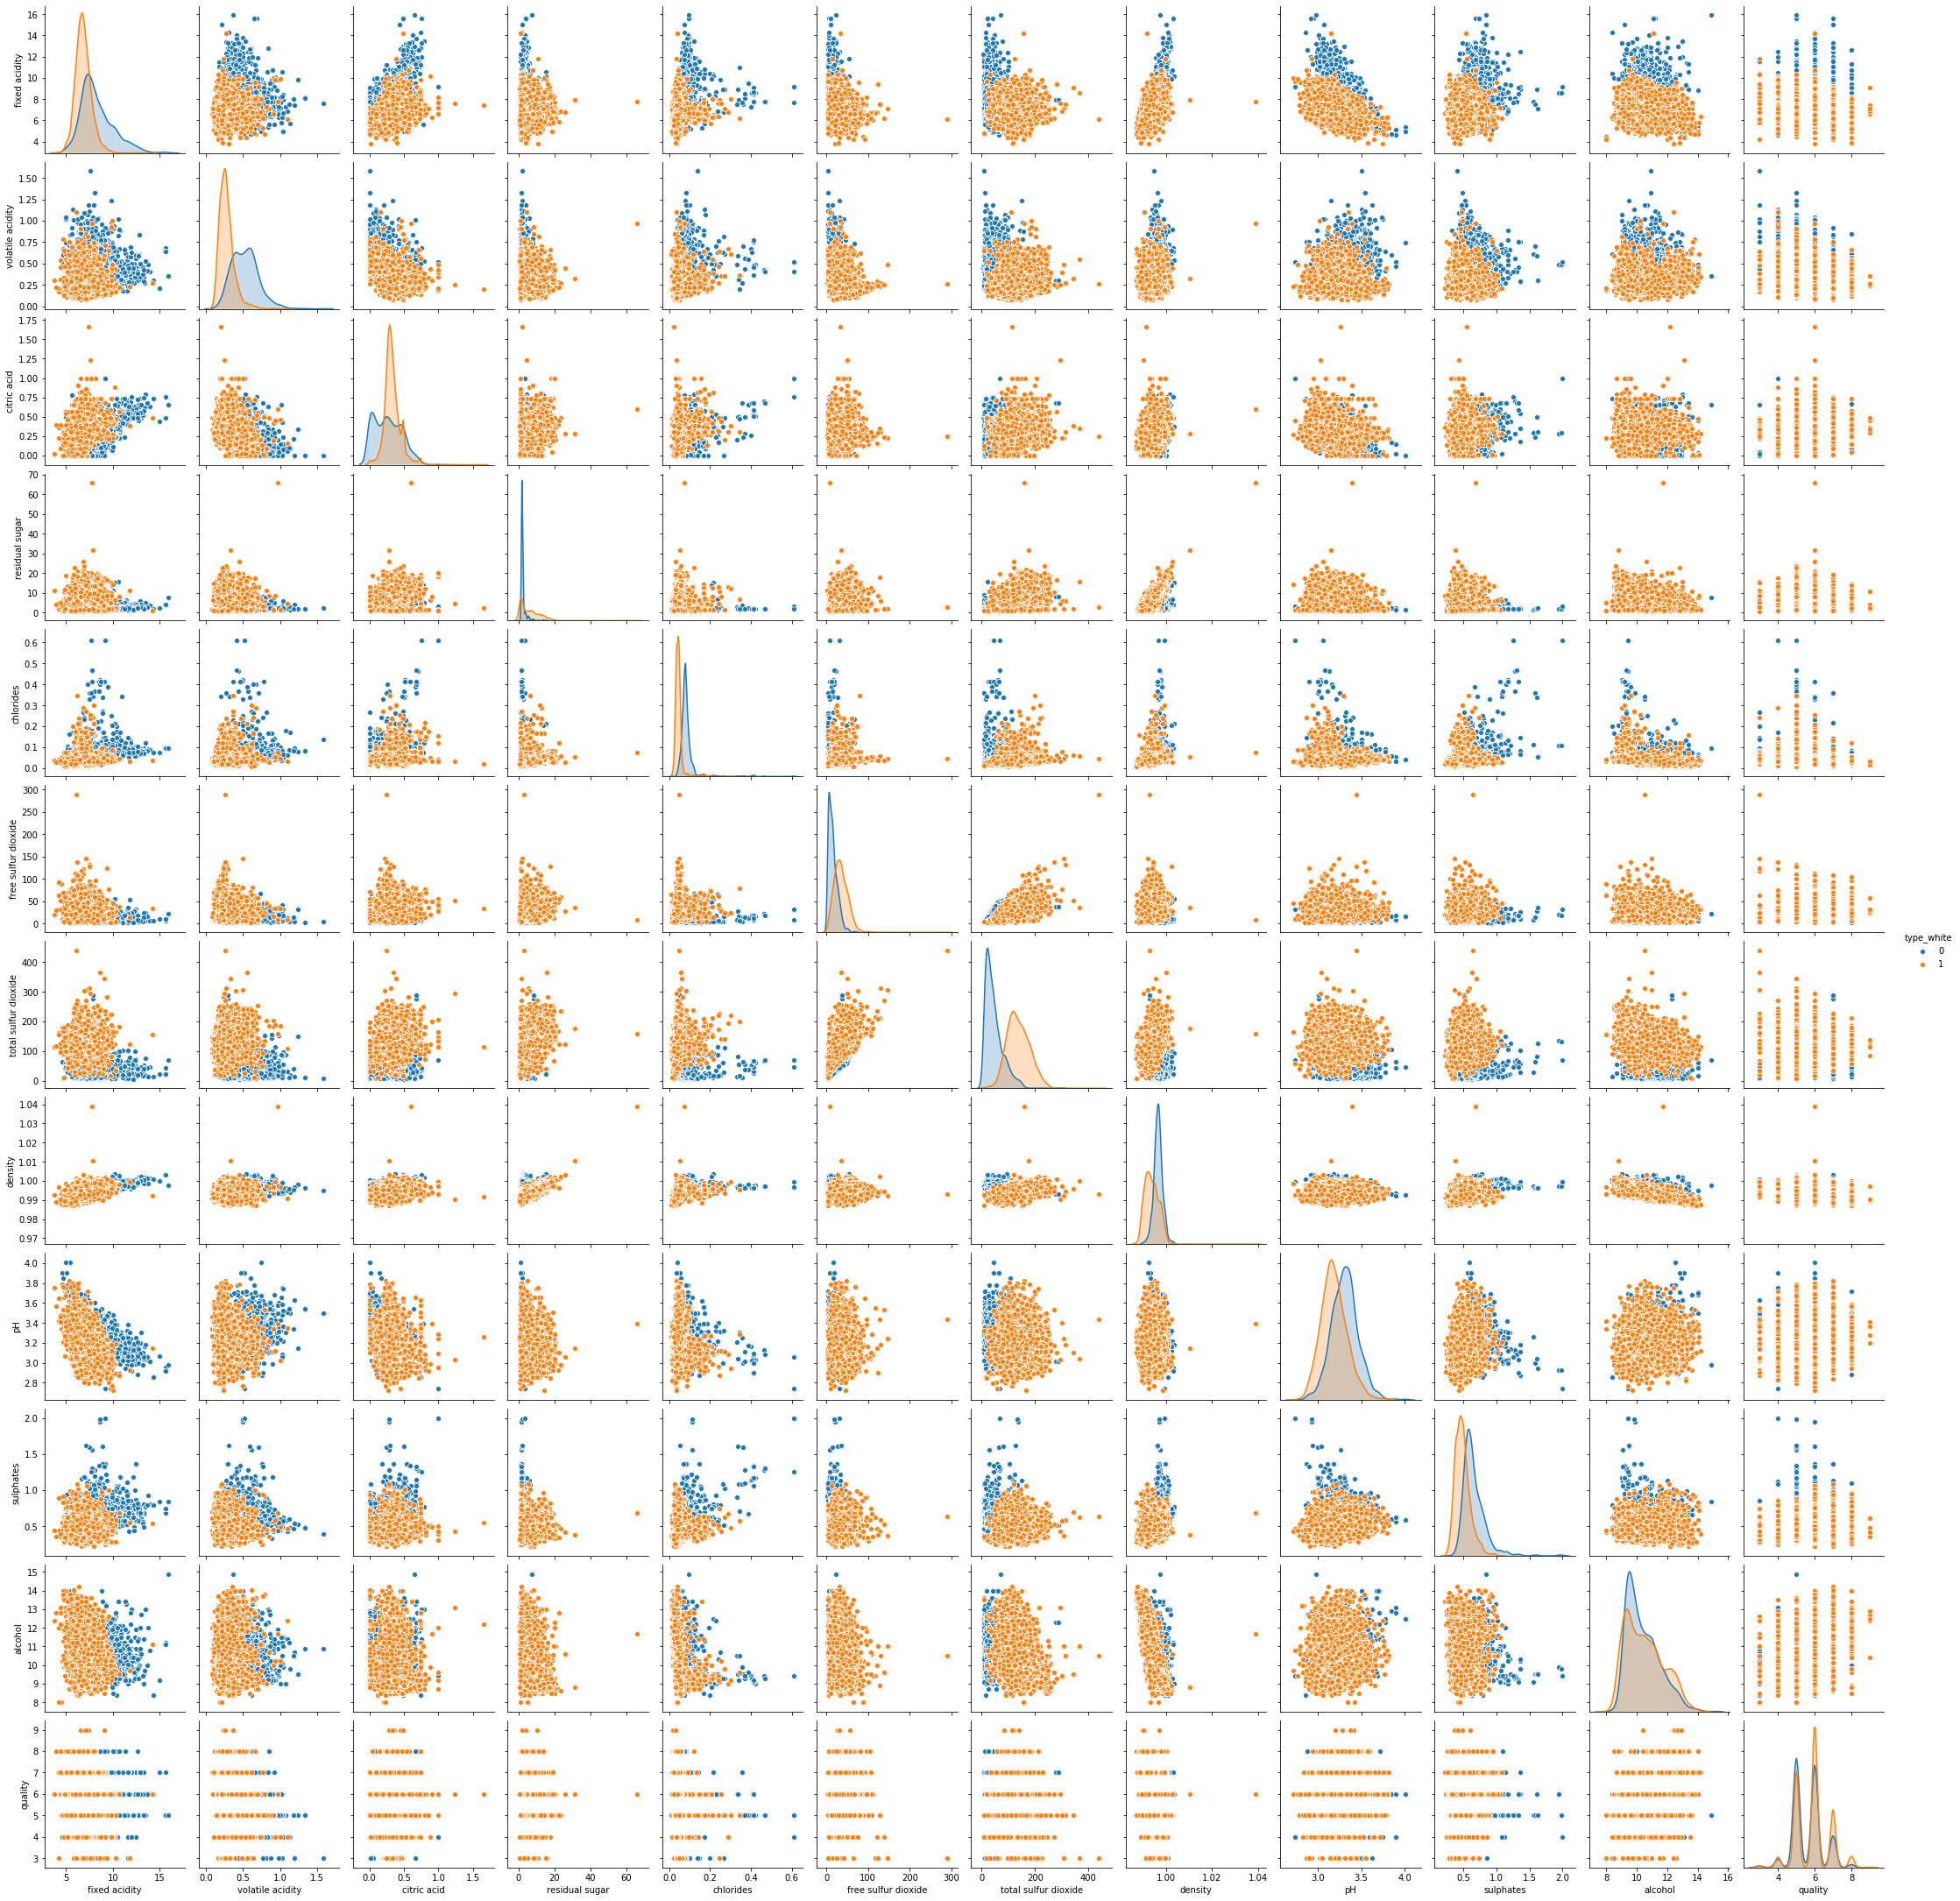

In [18]:
import seaborn as sns

sns.pairplot(wine, hue='type_white')
plt.show()

## Feature observations
In this pairplot, the points are colored by wine type (blue/orange points representing red/white wine, respectively). From a qualitative standpoint, there seems to be several features for which reds and whites are clearly separable. Thinking ahead towards the quality model, it may turn out that quality is determined differently for reds and whites. We may want to model these separately.

Let's color the plot a bit differently, this time by quality score. We'll make two plots to look at red and white separately.

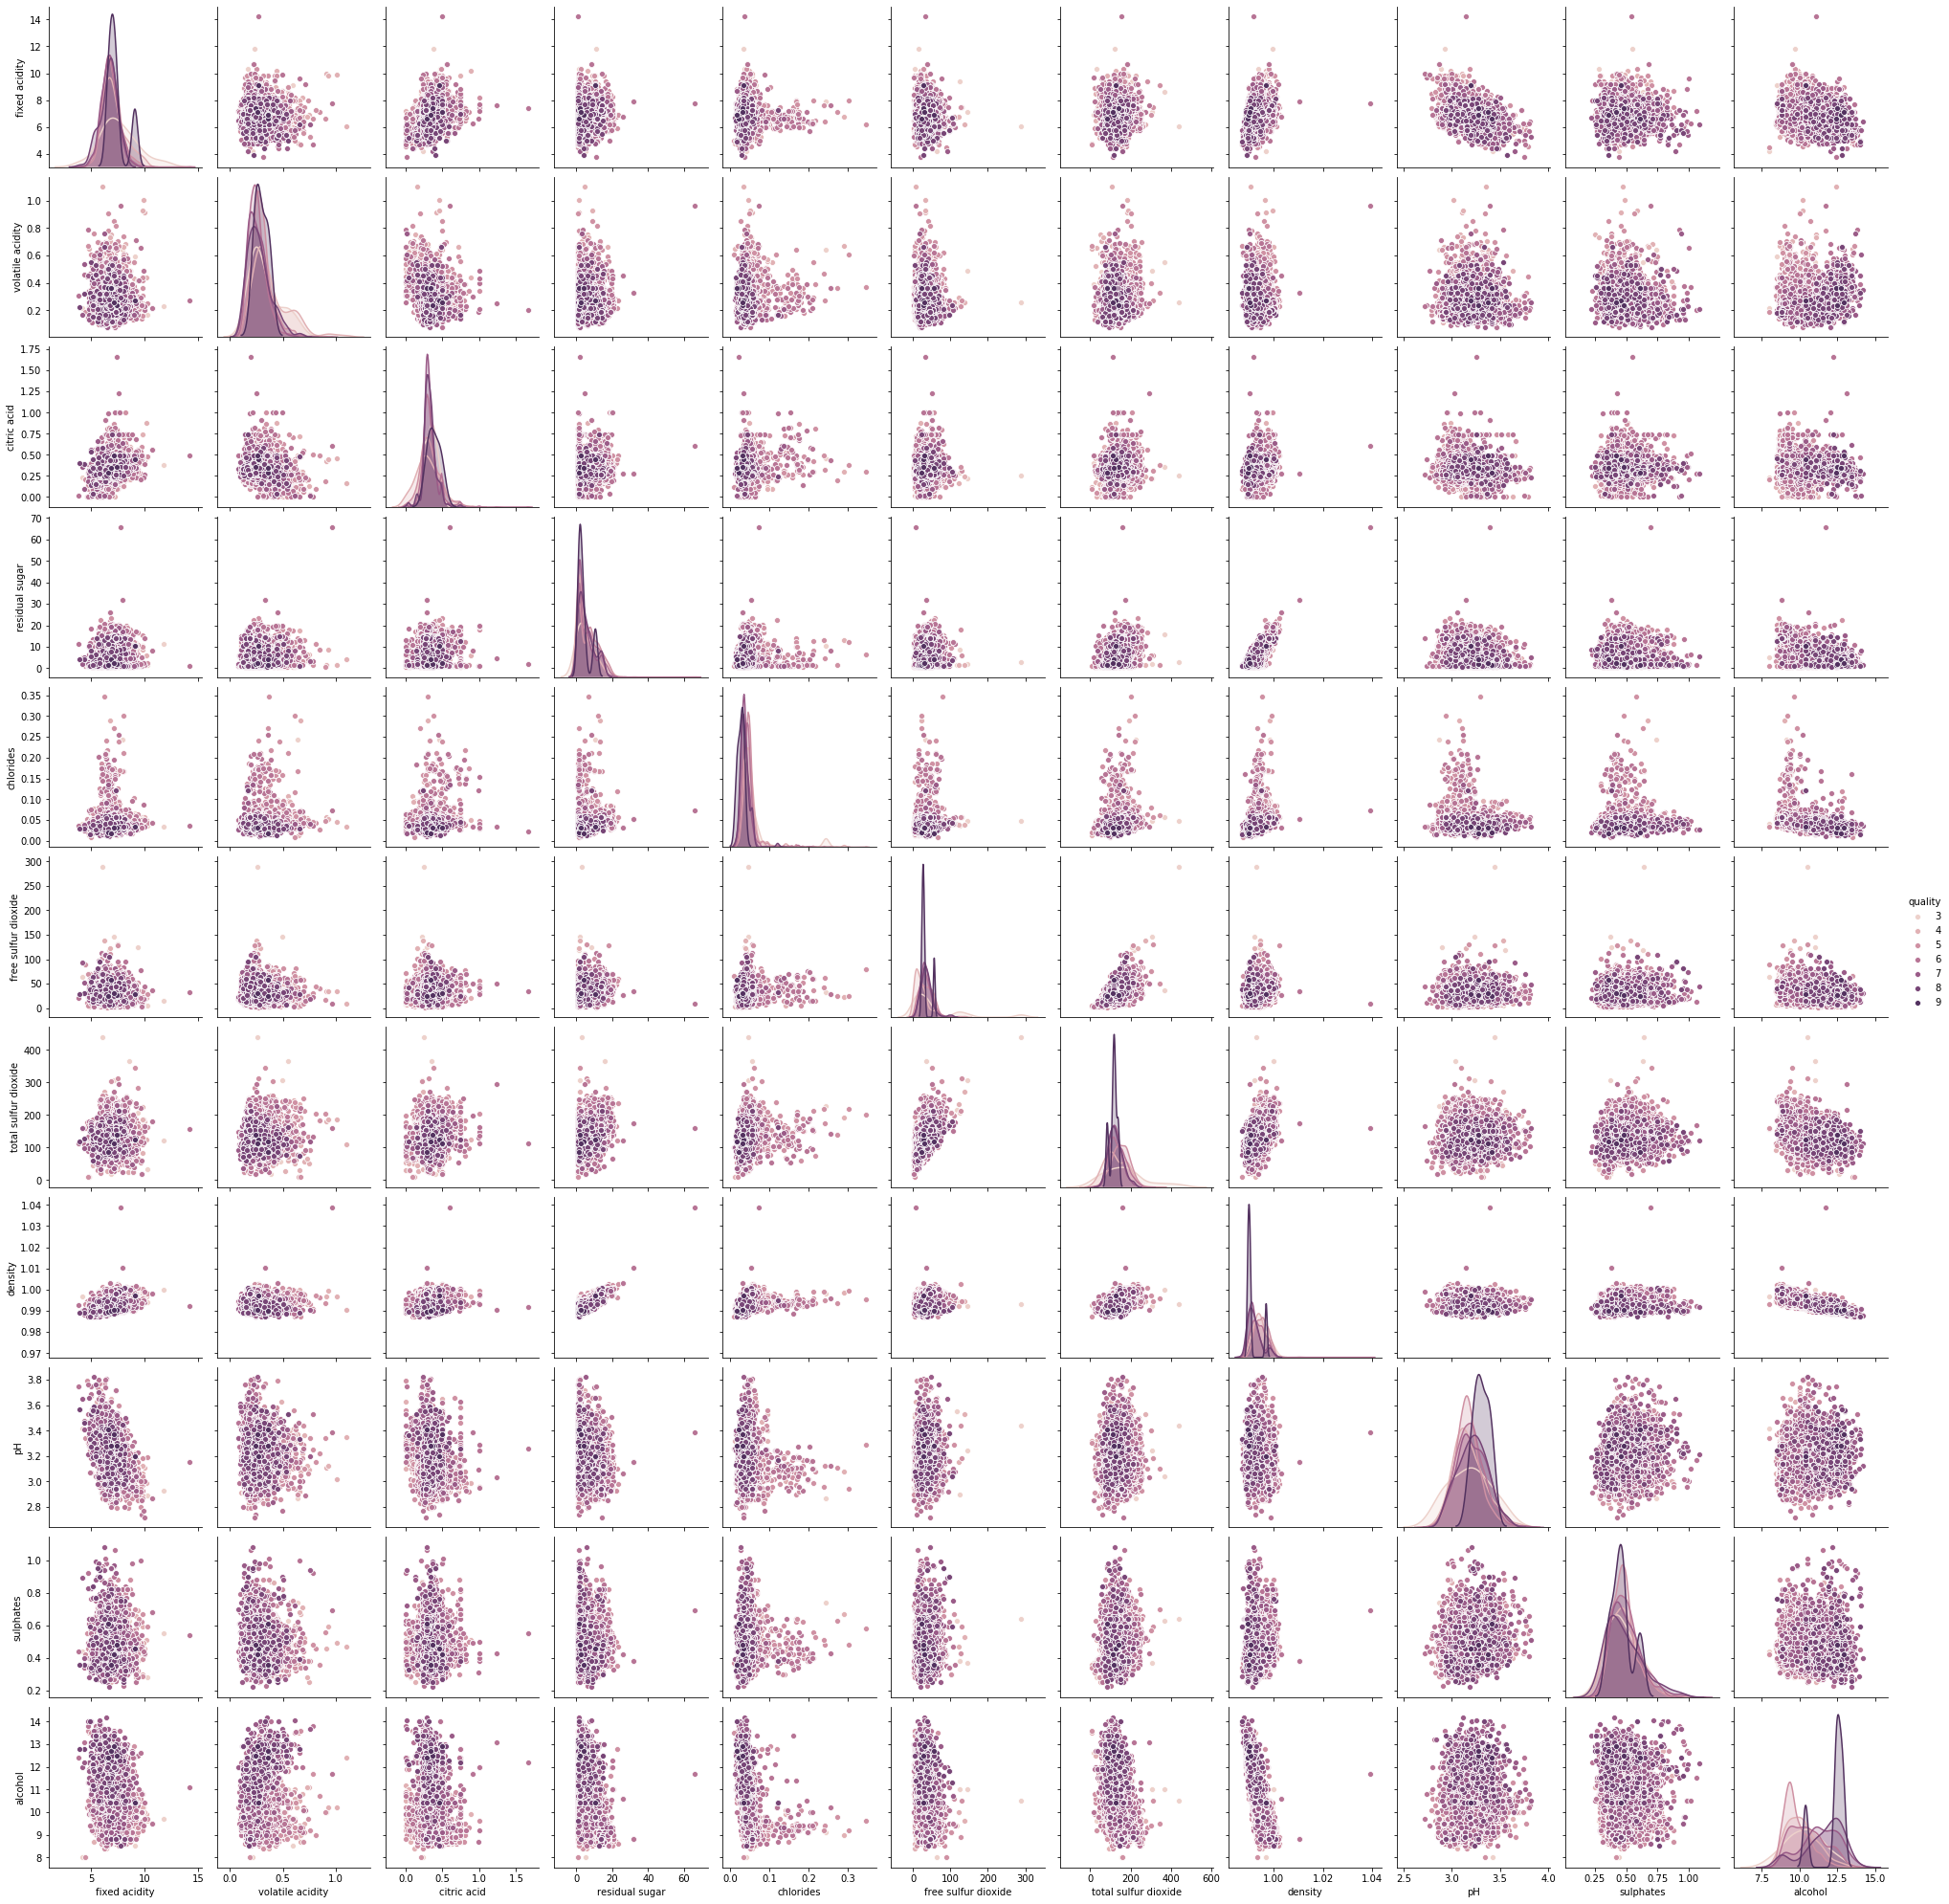

In [22]:
whites = wine[wine['type_white'] == 1].drop(['type_white'],axis=1)
reds = wine[wine['type_white'] == 0].drop(['type_white'],axis=1)
sns.pairplot(whites,hue='quality',palette=sns.cubehelix_palette(8))
plt.show()

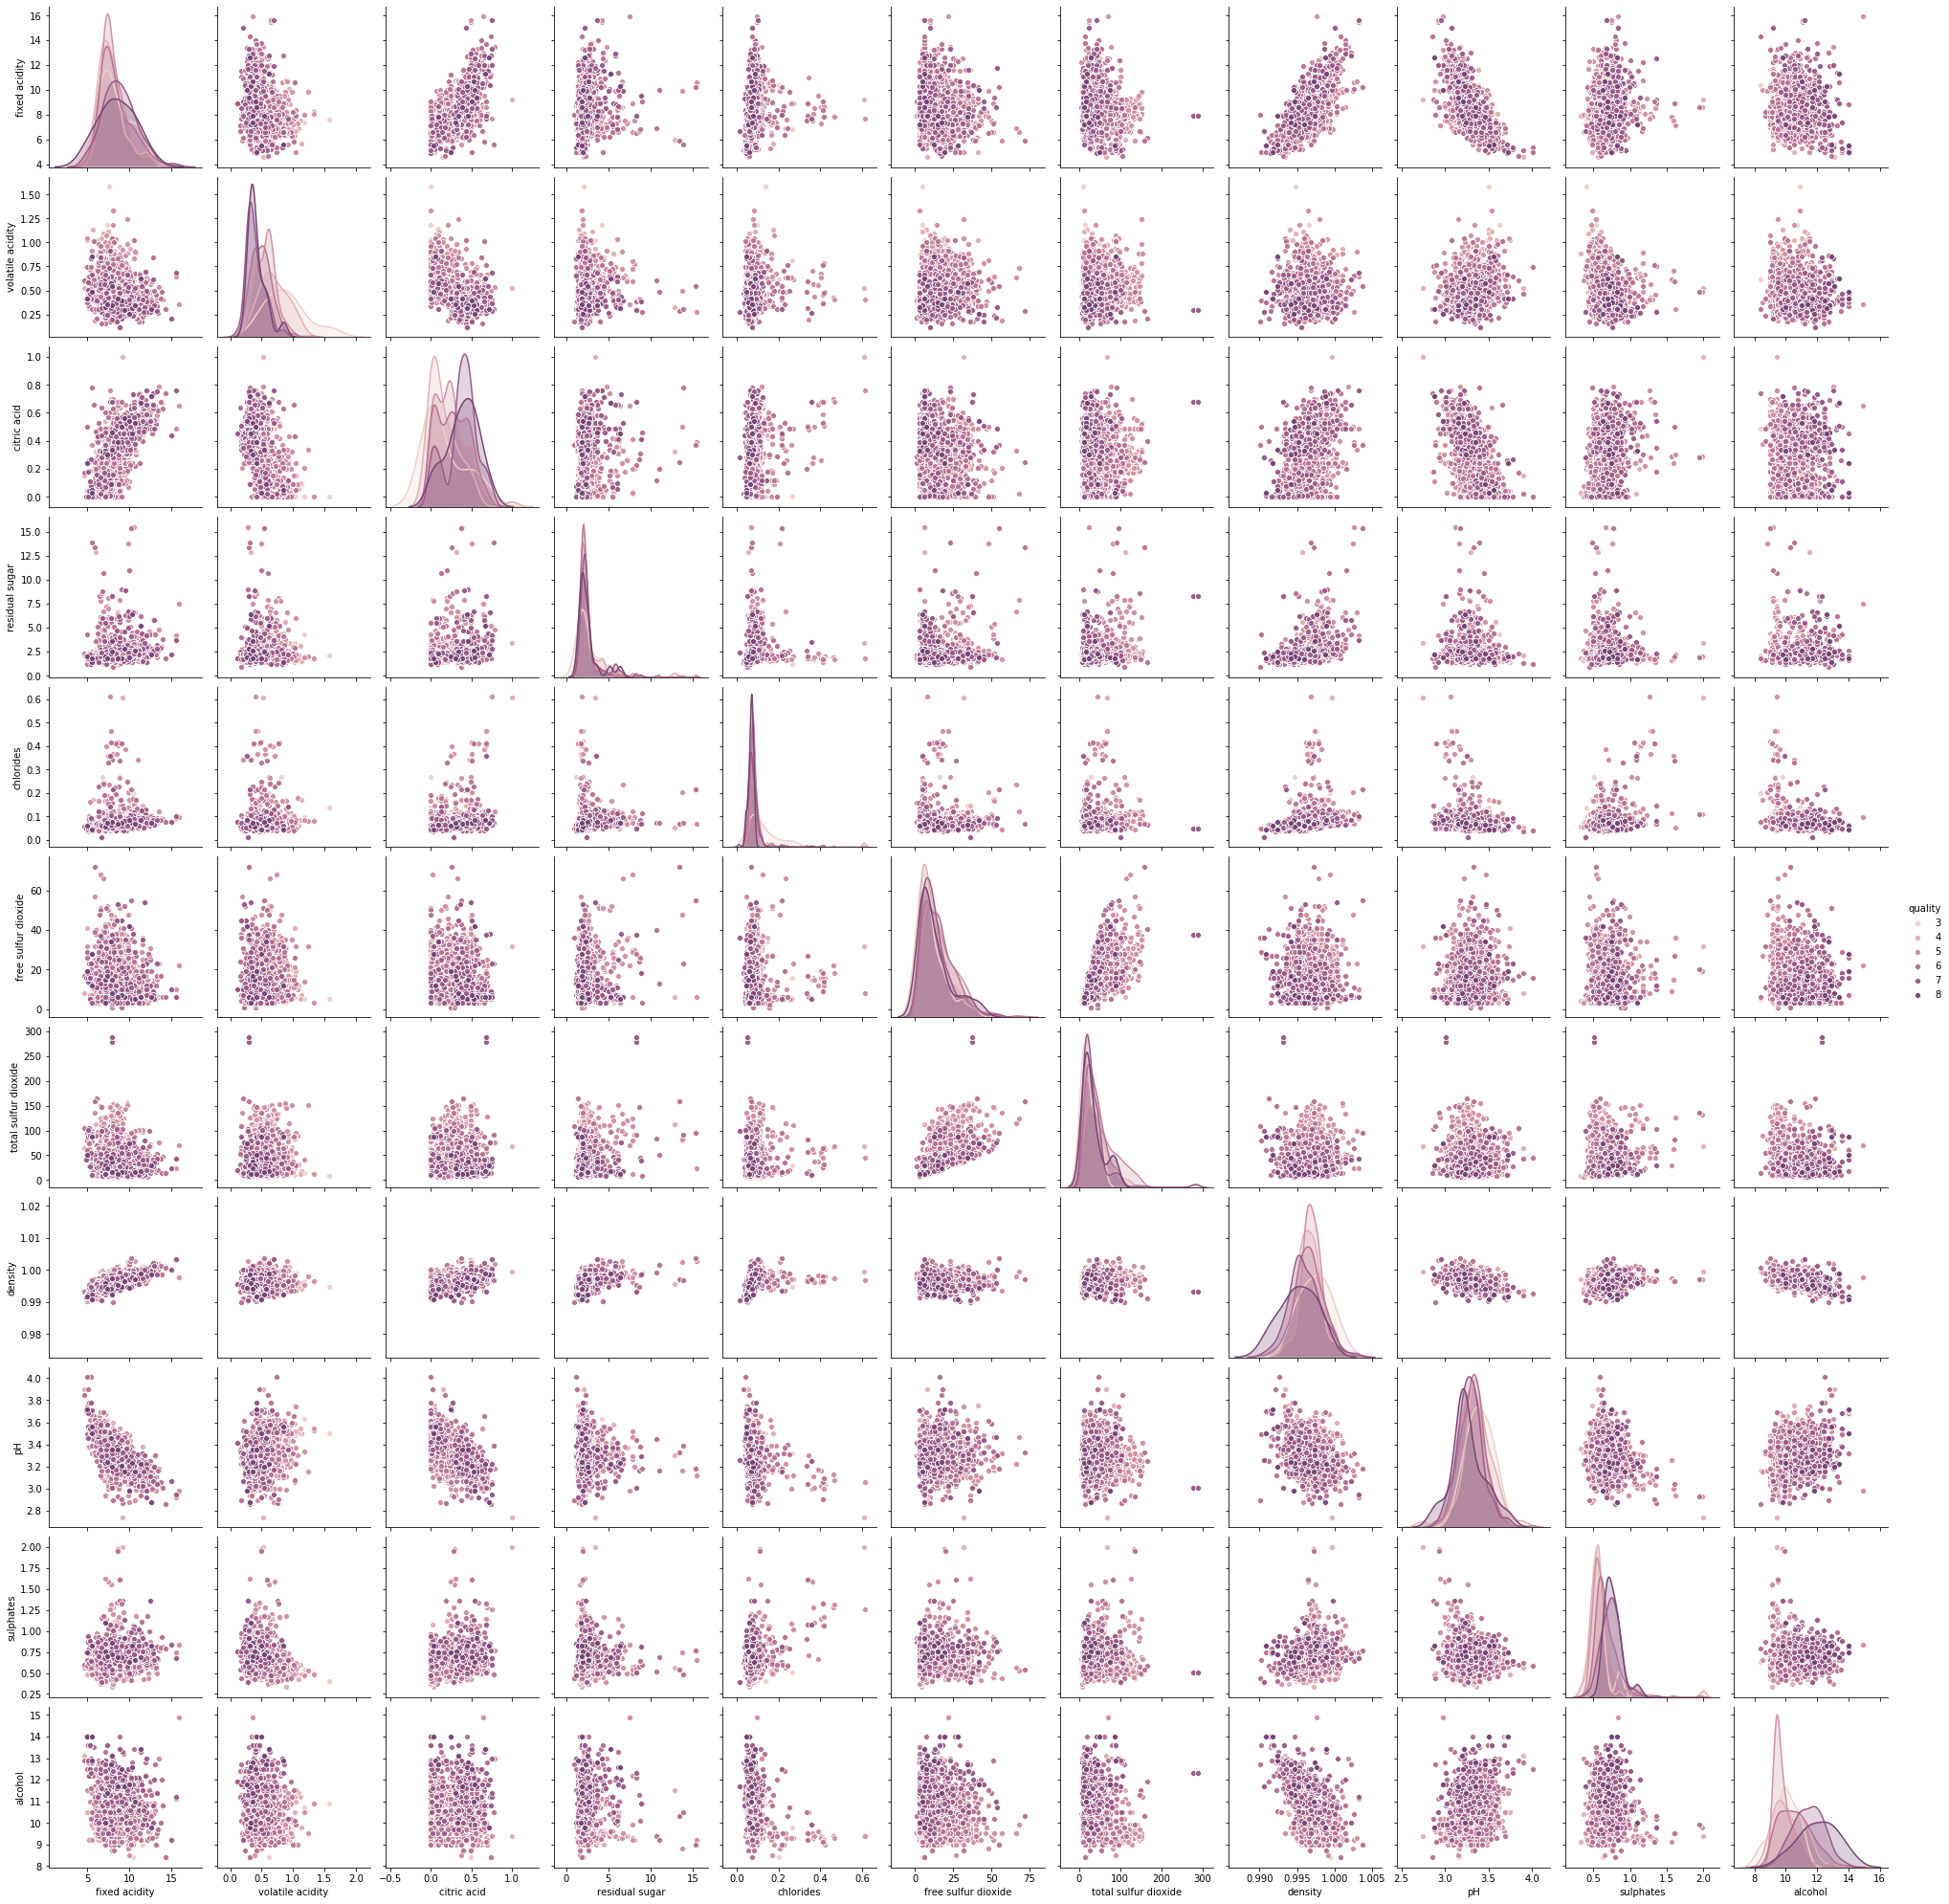

In [23]:
sns.pairplot(reds,hue='quality',palette=sns.cubehelix_palette(8))
plt.show()

## Pairplot observations
In these plots, darker colors represent higher quality scores. 

Next, let's have a look at correlation coefficients.

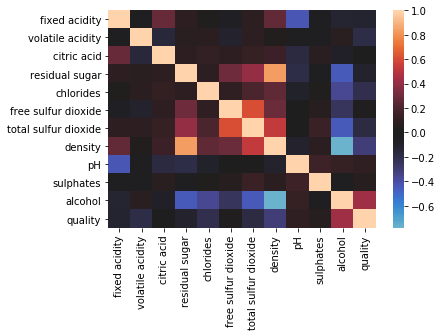

In [27]:
sns.heatmap(whites.corr(),center=0)
plt.show()

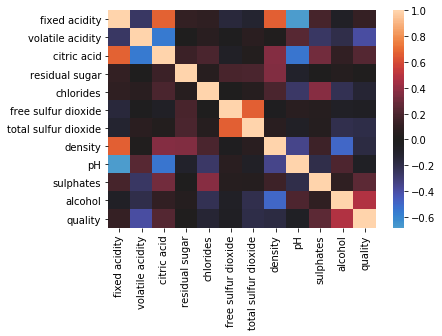

In [26]:
sns.heatmap(reds.corr(),center=0)
plt.show()

It looks like there's a strong positive correlation between alcohol and quality - more is better! ;~)

For whites, alcohol is negatively correlated with several features: residual sugar, chlorides, free sulfur dioxide  and total sulfur dioxide.

For reds, there's a strong positive correlation between fixed acidity and citric acid, and a strong negative correlation between citric acid and volatile acidity. Negative correlations between pH and both fixed acidity and citric acid.

## Principal Component Analysis
Let's run a PCA...

(4898, 2) (4898, 12)


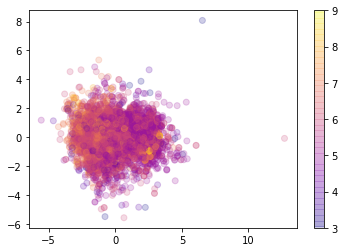

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

whites_std = StandardScaler().fit_transform(whites.drop(['quality'],axis=1))

pca = PCA(2)

pca.fit(whites_std)
white_components = pca.transform(whites_std)
print(white_components.shape,whites.shape)
plt.scatter(white_components[:,0],white_components[:,1],c=whites.quality,alpha=0.2,cmap='plasma')
plt.colorbar()
plt.show()

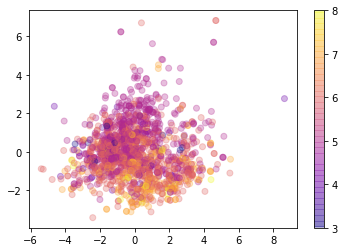

In [61]:
reds_std = StandardScaler().fit_transform(reds.drop(['quality'],axis=1))

pca = PCA(2)
pca.fit(reds_std)
red_components = pca.transform(reds_std)
plt.scatter(red_components[:,0],red_components[:,1],c=reds.quality,alpha=0.3,cmap='plasma')
plt.colorbar()
plt.show()

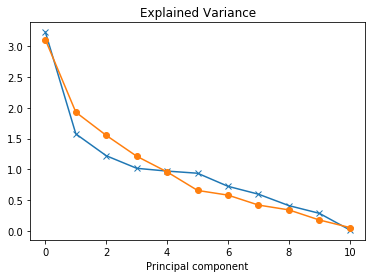

In [52]:
pca_whites = PCA()
pca_whites.fit(whites_std)
pca_reds = PCA()
pca_reds.fit(reds_std)
plt.plot(pca_whites.explained_variance_,marker='x')
plt.plot(pca_reds.explained_variance_,marker='o')
plt.title('Explained Variance')
plt.xlabel('Principal component')
plt.show()

## Kmeans
Let's have a look at some features developed by unsupervised learning using k-means.

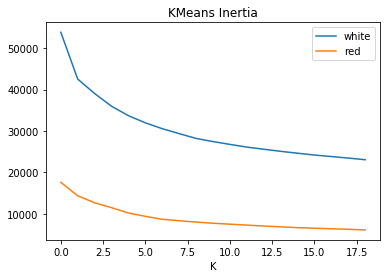

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import explained_variance_score

whiteInertia = []
redInertia = []

for i in range(1,20):
    KM = KMeans(i)
    KM.fit(whites_std)
    whiteInertia.append(KM.inertia_)
    KM.fit(reds_std)
    redInertia.append(KM.inertia_)
    
plt.plot(whiteInertia,label='white')
plt.plot(redInertia,label='red')
plt.legend()
plt.title('KMeans Inertia')
plt.xlabel('K')
plt.show()    